# 2D time-dependent heat equation

*2023-07-14*

This Notebook is based on the Github discussion of [DeepXDE library issue #61](https://github.com/lululxvi/deepxde/issues/61) on the time-dependent 2D heat equation.

References

- https://github.com/lululxvi/deepxde/issues/61
- https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/heat.html

Abbreviations

- DNN : Deep Neural Network
- IC : Initial Conditions
- BC : Bondary Conditions
- PDE : Partial Differential Equation

## Problem by wangcj05 on Jun 4, 2020

Using DeepXDE to solve 2D time-dependent heat equations, i.e

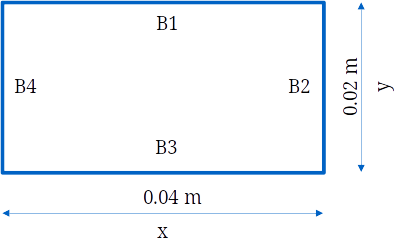

$ \frac {\rho c_p \partial T} {\partial t} -
k \cdot \frac {\partial^2 T} {\partial x^2} -
k \cdot \frac {\partial^2 T} {\partial y^2} = 0 $

$\rho$ = 8000, $c_p$ = 500, $k$ = 200, $t \in$ [0, 30 s],
$x \in$ [0, 0.04 m], $y \in$ [0, 0.02 m]

With Dirichlet boundary condition at B2, B3, B4, and Neuman boundary at B1. i.e.:

<table style="margin-left:0px;">

<tr>
    <td  style="padding-right:10em">
        $ T \vert_{x = 0 \ or \ x = 0.04} = 300 $
    </td>
    <td>
        left and right edges, B2 and B4
    </td>
</tr>

<tr>
    <td>
        $ T \vert_{y = 0} = 300 $ 
    </td>
    <td>
        botton edge, B3
    </td>
</tr>

<tr>
    <td> 
        $ n \cdot \frac{\partial T} {\partial n} \vert_{y = 0.02} = 0 $ 
    </td>
    <td>top edge, B1</td>
</tr>

</table>

IC :

$ T_{t = 0} = 1000 $

## Solution by Huzaifg on January 28, 2022

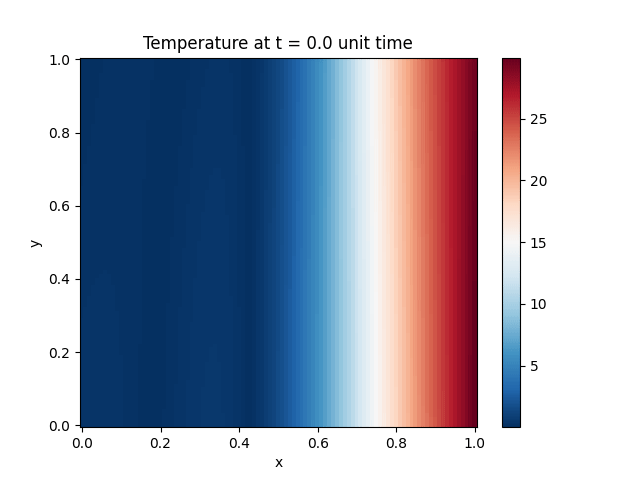

Equation given by

$ \rho cu_{,t} - k\nabla^2T = 0 \ \ on \ \ \Omega$

Subject to,

BC:

- T = 0°C along x = 0 m
- T = 30°C along x = 1 m

IC:

- T(x,y,0) = 0°C for x < 0.5 m and T(x,y,0) = 60(x-0.5)°C for x >= 0.5 m

Where,

$x \in [0,1] \ and \ y \in [0,1], \ k = 385 watt.m^{-1}C^{-1},$

$\rho = 6000 kg.m^{-3} \ and \ \rho c = 3.8151 \times 10^{3} N.m^{-2}.C^{-1}$

First, the equation is normalized

$ \rho cu_{,t} - k\nabla^2T = 0
\longrightarrow 
u_{,t} - \frac{k}{\rho c}\nabla^2T = 0 $

And made some modifications to the BC:

- T = 0 on left edge, and T = 1 ond the right edge.
- IC becomes T(x,y,0) = 0°C for x < 0.5 m, and T(x,y,0) = 2(x-0.5)°C for x >= 0.5 m.
- Apply a zero Neumann condition at the top and botton edges. Neumann BC does not naturally come about and needes to be explicity specified.
- While predictiong the output, we scale T by 30 to regain the problem BC.

An output transform is applied to ensure that the temperatures that the DNN (Deep Neural Network) was outputing were positive using

    net.apply_output_transform(lambda x, y: abs(y))

Given below is the complete code.

In [10]:
! nvidia-smi

Fri Jul 14 15:08:13 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050        Off | 00000000:01:00.0  On |                  N/A |
| N/A   43C    P8              N/A / ERR! |   1629MiB /  3072MiB |     12%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [34]:
import os
import tensorflow as tf
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [35]:
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np
from deepxde.backend import tf
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

About the functions used below:

`deepxde.gradients.hessian`

https://deepxde.readthedocs.io/en/latest/modules/deepxde.html?highlight=hessian#deepxde.gradients.hessian

Compute Hessian matrix H:

    H[i][j] = d^2y / dx_i dx_j, where i,j=0,…,dim_x-1

Use this function to compute second-order derivatives instead of tf.gradients() or torch.autograd.grad()

`dde.grad.jacobian`

https://deepxde.readthedocs.io/en/latest/modules/deepxde.html?highlight=hessian#deepxde.gradients.jacobian

Compute Jacobian matrix J: 

    J[i][j] = dy_i / dx_j, where i = 0, …, dim_y - 1 and j = 0, …, dim_x - 1

Use this function to compute first-order derivatives instead of tf.gradients() or torch.autograd.grad()

In [36]:
# Some useful functions


def pde(X, T):
    dT_xx = dde.grad.hessian(T, X, j=0)
    dT_yy = dde.grad.hessian(T, X, j=1)
    dT_t = dde.grad.jacobian(T, X, j=2)
    # Dividing by rhoc to make it 1
    rhoc = (3.8151 * 10**3) / (3.8151 * 10**3)
    kap = (385 / (3.8151 * 10**3))
    # no forcing function
    return ((rhoc * dT_t) - (kap * (dT_xx + dT_yy)))


def r_boundary(X, on_boundary):
    x, y, t = X
    return on_boundary and np.isclose(x, 1)


def l_boundary(X, on_boundary):
    x, y, t = X
    return on_boundary and np.isclose(x, 0)


def up_boundary(X, on_boundary):
    x, y, t = X
    return on_boundary and np.isclose(y, 1)


def down_boundary(X, on_boundary):
    x, y, t = X
    return on_boundary and np.isclose(y, 0)


def boundary_initial(X, on_initial):
    x, y, t = X
    return on_initial and np.isclose(t, 0)


def init_func(X):
    x = X[:, 0:1]
    y = X[:, 1:2]
    t = np.zeros((len(X), 1))
    for count, x_ in enumerate(x):
        if x_ < 0.5:
            t[count] = t1
        else:
            t[count] = t1 + (2) * (x_ - 0.5)
    return t


def dir_func_l(X):
    return t1 * np.ones((len(X), 1))


def dir_func_r(X):
    return t2 * np.ones((len(X), 1))


def func_zero(X):
    return np.zeros((len(X), 1))


def hard(X, T):
    x, y, t = x[:, 0:1], x[:, 1:2], x[:, 2:3]
    return (r - r_in) * y + T_star

\
Parameters

In [37]:
t1 = 0
t2 = 1
end_time = 1

# number of training points within domain Tf: random points (spatio-temporal domain)
num_domain = 30000    # 30000

# number of training boundary condition points on the geometry boundary: Tb
num_boundary = 8000    # 8000

# number of training initial condition points: Tb
num_initial = 20000    # 20000

# number of epochs for training
epochs = 10000    #10000

# learning rate
lr = 1e-3

# Applying Loss weights as given below
loss_weights = [
    10,  # PDE Loss
    1,  # BC1 loss - Dirichlet Left
    1,  # BC2 loss - Dirichlet Right
    1,  # BC3 loss - Neumann up
    1,  # BC4 loss - Neumann down
    10  # IC Loss
]

optimizer = "adam"
batch_size_ = 256

About the functions used below:

`geometry.TimeDomain(0, 3)`

$ t \in [0, 3] $

We begin by defining a computational geometry and time domain. We can use a built-in class `Interval` and `TimeDomain` and we combine both the domains using `GeometryXTime` :

In [38]:
geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])
timedomain = dde.geometry.TimeDomain(0, end_time)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [39]:
bc_l = dde.DirichletBC(geomtime, dir_func_l, l_boundary)
bc_r = dde.DirichletBC(geomtime, dir_func_r, r_boundary)
bc_up = dde.NeumannBC(geomtime, func_zero, up_boundary)
bc_low = dde.NeumannBC(geomtime, func_zero, down_boundary)
ic = dde.IC(geomtime, init_func, boundary_initial)

\
“data”: geometry + PDE + BC/IC + “training” points:

In [40]:
data = dde.data.TimePDE(geomtime,
                        pde, [bc_l, bc_r, bc_up, bc_low, ic],
                        num_domain=num_domain,
                        num_boundary=num_boundary,
                        num_initial=num_initial)

hidden_layer_size = 60  # size of each hidden layers
num_hidden_layer = 5  # number of hidden layers for DNN
layer_size = [3] + [hidden_layer_size] * num_hidden_layer + [1]

activation_func = "tanh"
initializer = "Glorot uniform"

net = dde.maps.FNN(layer_size, activation_func, initializer)

# Applied a output transform to ensure that the tempretures that the DNN
# was outputing were positive using:
net.apply_output_transform(lambda x, y: abs(y))

## Uncomment below line to apply hard Dirichlet Boundary Conditions
# net.outputs_modify(lambda x, y: x[:,0:1]*t2 + x[:,0:1] * (1 - x[:,0:1]) * y)

model = dde.Model(data, net)

model.compile(optimizer, lr=lr, loss_weights=loss_weights)

# To save the best model every 1000 epochs
checker = dde.callbacks.ModelCheckpoint("model/model1.ckpt",
                                        save_better_only=True,
                                        period=1000)
losshistory, trainstate = model.train(iterations=epochs,
                                      batch_size=batch_size_,
                                      callbacks=[checker])

Compiling model...
Building feed-forward neural network...


/home/x/miniconda3/envs/tf/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 1.232400 s



2023-07-15 00:55:41.722732: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2449 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


'compile' took 3.645298 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.14e-02, 2.44e-02, 8.90e-01, 2.97e-02, 4.71e-02, 1.42e+00]    [6.14e-02, 2.44e-02, 8.90e-01, 2.97e-02, 4.71e-02, 1.42e+00]    []  
1000      [1.08e-03, 2.26e-04, 1.66e-04, 8.32e-04, 4.87e-05, 5.74e-03]    [1.08e-03, 2.26e-04, 1.66e-04, 8.32e-04, 4.87e-05, 5.74e-03]    []  
2000      [2.25e-03, 2.43e-04, 9.31e-05, 8.39e-04, 5.15e-05, 6.36e-03]    [2.25e-03, 2.43e-04, 9.31e-05, 8.39e-04, 5.15e-05, 6.36e-03]    []  
3000      [2.74e-04, 1.33e-04, 9.01e-05, 8.18e-04, 7.94e-06, 2.40e-03]    [2.74e-04, 1.33e-04, 9.01e-05, 8.18e-04, 7.94e-06, 2.40e-03]    []  
4000      [2.15e-04, 1.72e-04, 5.81e-05, 8.34e-04, 4.52e-06, 1.63e-03]    [2.15e-04, 1.72e-04, 5.81e-05, 8.34e-04, 4.52e-06, 1.63e-03]    []  
5000      [3.79e-04, 2.11e-04, 1.88e-04, 8.30e-04, 4.12e-06, 1.61e-03]    [3.79e-04, 2.11

Use L-BFGS algorithm to minimize a differentiable function.
Performs unconstrained minimization of a differentiable function using the L-BFGS scheme.

https://en.wikipedia.org/wiki/Limited-memory_BFGS

Limited-memory BFGS (L-BFGS or LM-BFGS) is an optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory. It is a popular algorithm for parameter estimation in machine learning. The algorithm's target problem is to minimize $\displaystyle f(\mathbf {x} )$ over unconstrained values of the real-vector $\displaystyle \mathbf {x} $ where $\displaystyle f$ is a differentiable scalar function. The L-BFGS-B algorithm extends L-BFGS to handle simple box constraints (aka bound constraints) on variables.

In [41]:
model.compile("L-BFGS-B")

Compiling model...
'compile' took 2.144986 s



set_LBFGS_options https://deepxde.readthedocs.io/en/latest/modules/deepxde.optimizers.html

Sets the hyperparameters of L-BFGS

The L-BFGS optimizer used in each backend:

    TensorFlow 1.x: scipy.optimize.minimize
    TensorFlow 2.x: tfp.optimizer.lbfgs_minimize
    PyTorch: torch.optim.LBFGS

maxcor (int) - The maximum number of variable metric corrections used to define the limited memory matrix. (The limited memory BFGS method does not store the full hessian but uses this many terms in an approximation to it.)

In [42]:
dde.optimizers.set_LBFGS_options(maxcor=50)

### Train

Need to check if GPU is used to train

In [43]:
losshistory, train_state = model.train(iterations=epochs, batch_size=batch_size_)

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
10000     [1.47e-05, 1.11e-04, 9.02e-06, 8.40e-04, 1.28e-06, 8.52e-05]    [1.47e-05, 1.11e-04, 9.02e-06, 8.40e-04, 1.28e-06, 8.52e-05]    []  
11000     [2.59e-05, 9.04e-07, 1.61e-05, 7.68e-04, 1.84e-06, 4.50e-05]    [2.59e-05, 9.04e-07, 1.61e-05, 7.68e-04, 1.84e-06, 4.50e-05]        
12000     [4.03e-05, 6.00e-07, 2.09e-05, 7.23e-04, 2.92e-06, 2.83e-05]    [4.03e-05, 6.00e-07, 2.09e-05, 7.23e-04, 2.92e-06, 2.83e-05]        
13000     [6.86e-05, 6.87e-07, 4.18e-05, 5.99e-04, 4.53e-06, 2.23e-05]    [6.86e-05, 6.87e-07, 4.18e-05, 5.99e-04, 4.53e-06, 2.23e-05]        
14000     [9.91e-05, 1.41e-06, 9.50e-05, 1.45e-04, 6.51e-06, 2.50e-05]    [9.91e-05, 1.41e-06, 9.50e-05, 1.45e-04, 6.51e-06, 2.50e-05]        
15000     [3.05e-05, 4.57e-07, 2.52e-05, 1.53e-05, 1.18e-06, 1.84e-05]    [3.05e-05, 4.57e-07, 2.52e-05, 1.53e-05, 1

Saving loss history to /home/x/Documents/inpe/dout/nde/DeepXDE/wang/loss.dat ...
Saving training data to /home/x/Documents/inpe/dout/nde/DeepXDE/wang/train.dat ...
Saving test data to /home/x/Documents/inpe/dout/nde/DeepXDE/wang/test.dat ...


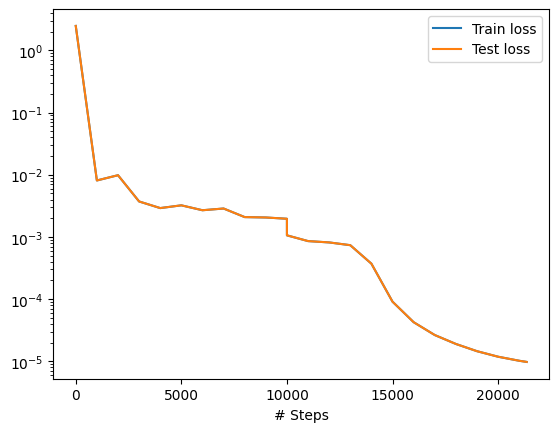

In [50]:
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)

In [51]:
# Save the entire model as a SavedModel.
! mkdir -p saved_model
model.save('saved_model/my_model')

'saved_model/my_model-21353.ckpt'

In [ ]:
# model = tf.keras.models.load_model('saved_model/my_model')

In [ ]:
# Check its architecture
#model.summary()

# PREDICTION

Prediction of the temperature for a paticular time frame:

**add_subplot**: "111" means "1x1 grid, first subplot" and "234" means "2x3 grid, 4th subplot". Alternative form for add_subplot(111) is add_subplot(1, 1, 1).
https://stackoverflow.com/questions/3584805/in-matplotlib-what-does-the-argument-mean-in-fig-add-subplot111

In [52]:
# ax = fig.add_subplot(111)
nelx = 100
nely = 100
timesteps = 101

x = np.linspace(0, 1, nelx + 1)
y = np.linspace(0, 1, nely + 1)
t = np.linspace(0, 1, timesteps)
xx, yy = np.meshgrid(x, y)

x_ = np.zeros(shape=((nelx + 1) * (nely + 1),))
y_ = np.zeros(shape=((nelx + 1) * (nely + 1),))
for c1, ycor in enumerate(y):
    for c2, xcor in enumerate(x):
        x_[c1 * (nelx + 1) + c2] = xcor
        y_[c1 * (nelx + 1) + c2] = ycor
Ts = []

for time in t:
    t_ = np.ones((nelx + 1) * (nely + 1),) * (time)
    X = np.column_stack((x_, y_))
    X = np.column_stack((X, t_))
    #----------------------------------------
    T = model.predict(X)  #<<<<<<<<<<<<<<
    #----------------------------------------
    T = T * 30
    T = T.reshape(T.shape[0],)
    T = T.reshape(nelx + 1, nely + 1)
    Ts.append(T)


def plotheatmap(T, time):
    plt.clf()  # Clear the current plot figure
    plt.title(f"Temperature at t = {time*delta_t:.1f} unit time")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.pcolor(xx, yy, T, cmap='RdBu_r', shading='auto')
    plt.colorbar()
    return plt


def animate(k):
    plotheatmap(Ts[k], k)


delta_t = t[1] - t[0]

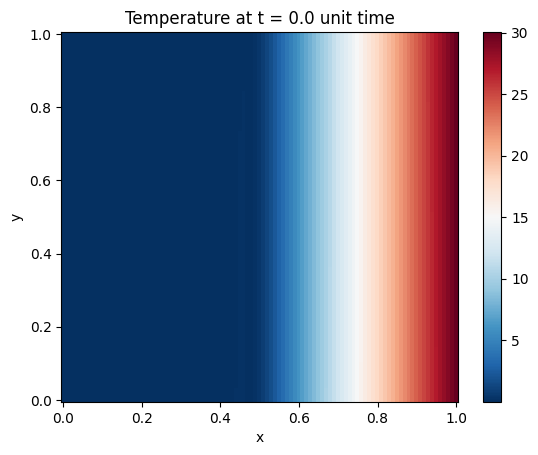

In [53]:
animate(0)

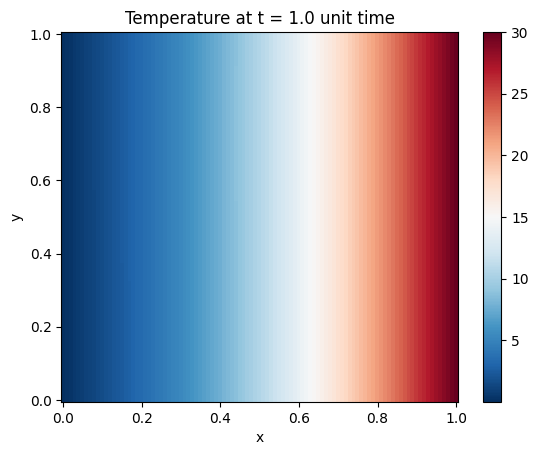

In [54]:
animate(100)

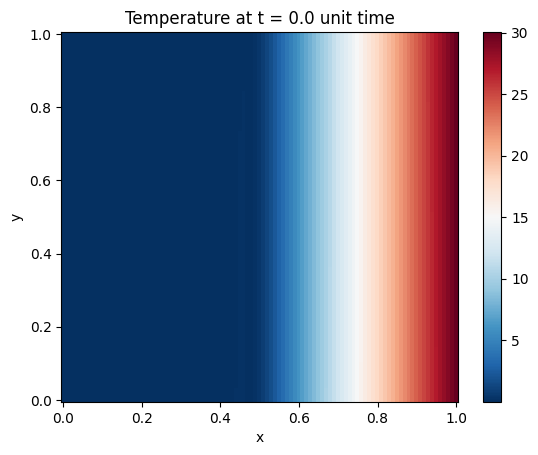

In [57]:
anim = animation.FuncAnimation(plt.figure(),
                               animate,
                               #interval=1,  #default 200 ms
                               frames=timesteps)

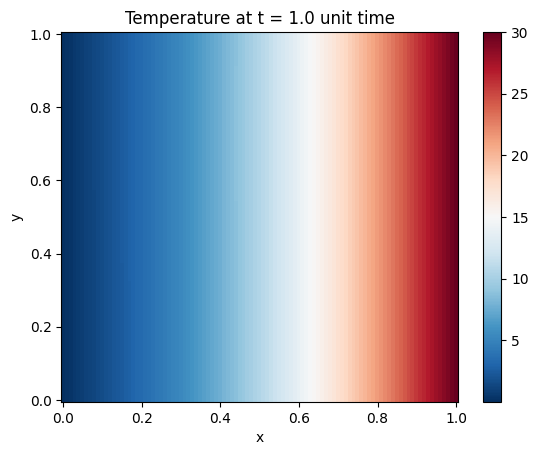

In [58]:
anim.save("trial.gif")